In [1]:
 # Prophet 시각화 도구 
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly 
from prophet.plot import add_changepoints_to_plot
from prophet.utilities import regressor_coefficients

In [2]:
# data preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/기상청 공모전/train_final.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/기상청 공모전/test_final.csv')
index_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/기상청 공모전/smart_farm_final.csv')
save_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/기상청 공모전/smart_farm_final_scaled_ver7.csv')

In [5]:
test_df_re = index_df[index_df['시간']>'2022-03-01']
test_df_re = test_df_re[['시간','열공급량(kWh)']]
test_df_re.reset_index(drop= True,inplace=True)

In [6]:
index_list = index_df['시간']
df_index = index_list[index_list<'2022-03-01']
df['시간'] = df_index 

In [7]:
temp = pd.DataFrame(index_list[index_list>'2022-03-01'])
temp.reset_index(inplace=True,drop=True)
test_df['시간'] = temp['시간']

In [8]:
col1 = test_df.columns[-2:].to_list()
col1.reverse()
col2 = test_df.columns[:-2].to_list()
col_list = col1+col2
test_df = test_df[col_list]
test_df.rename(columns = {'시간':'ds','열공급량(kWh)':'y'},inplace = True)

In [9]:
col1 = df.columns[-2:].to_list()
col1.reverse()
col2 = df.columns[:-2].to_list()
col_list = col1+col2
df = df[col_list]
df.rename(columns = {'시간':'ds','열공급량(kWh)':'y'},inplace = True)

In [11]:
y_train_prophet_df  = df[['ds','y']]

In [12]:
x_col = [i for i in df.columns if i not in ['ds','y']] 
x_train_prophet_df = df[x_col] 

In [13]:
yx_train_prophet_df = pd.concat([y_train_prophet_df, x_train_prophet_df],axis=1)

In [14]:
import datetime
date_list = []
for i in yx_train_prophet_df['ds']:
  date_time_obj = datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S')
  date_list.append(date_time_obj)
yx_train_prophet_df['ds'] = date_list

# 함수화

In [15]:
regressor_list = [
 '난방온도(설정온도)',
 '내부 습도',
 '내부 온도',
 '년도',
 '누적강수량',
 '배기팬',
 '아황산가스_1시간',
 '에너지스크린(수직)',
 '에너지스크린(수평)',
 '외기습도(%)',
 '유동팬',
 '일사량(W/㎡)',
 '일산화탄소_1시간',
 '지면온도',
 '차광스크린(수평)',
 '차광스크린_개방',
 '차열스크린(수평)',
 '천창',
 '팬코일 B동',
 '풍향(º)',
 '현지기압',
 '환기온도(천창 제어온도)']

In [16]:
final_df = pd.concat([df,test_df])
final_df.reset_index(drop=True,inplace=True)

In [17]:
save_final_df = pd.concat([df,save_df])
save_final_df.reset_index(drop=True,inplace=True)

In [18]:
def modeling(n_changepoints,changepoint_prior_scale,seasonality_prior_scale):
    fit_default_prophet = Prophet(growth='linear',
    # 2) Trend                                                
    changepoints=None, # CP가 발생하는 시점들의 list                                              
    n_changepoints=n_changepoints, # CP의 수                                                
    changepoint_range=0.8, # CP의 기존 데이터 수 대비 최대 비율                                                
    changepoint_prior_scale=changepoint_prior_scale, # CP 추정 민감도로 높을수록 민감                                                
    # 3) Seasonality                                                
    seasonality_mode='additive', # 계절성 모델: 'additive' or 'multiplicative'                                               
    seasonality_prior_scale=seasonality_prior_scale, # 계절성 추정 민감도로 높을수록 민감   0.1부터 10사이                                             
    yearly_seasonality='auto', # 연계절성                                                
    weekly_seasonality='auto',# 월계절성                                                
    daily_seasonality='auto', #일계절성                                               
    # 4) Holiday                                               
    holidays=None, # 휴일 또는 이벤트 시점                                                                                       
    # 5) Others                                              
    interval_width=0.8, # 추세 예측 정확도 구간범위                                              
    mcmc_samples=0, # 계절성
    )
    fit_default_prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    for i in regressor_list:
      fit_default_prophet.add_regressor(i,prior_scale = 0.4,standardize = False,mode = 'additive')
    # model 학습 
    fit_reg1_prophet = fit_default_prophet.fit(yx_train_prophet_df) 
    # Frequency에 대한 사전 df를 만듦 
    forecast = fit_reg1_prophet.make_future_dataframe(
        freq='min',
        periods=18720)
    for i in regressor_list:
      forecast[i] = final_df[i]
    pred_reg1_prophet = fit_reg1_prophet.predict(forecast) 
    pred_train_reg1_prophet = np.ravel(pred_reg1_prophet.loc[:yx_train_prophet_df.shape[0]-1, ['yhat']])
    pred_test_reg1_prophet = np.ravel(pred_reg1_prophet.loc[yx_train_prophet_df.shape[0]:, ['yhat']])
    test_df_re['열공급량(kWh)'] =pred_test_reg1_prophet
    # test_df_re['열공급량(kWh)'] =np.concatenate((pred_test_reg1_prophet[:14400], pred_test_reg1_prophet[-4320:]))
    test_df_re['열공급량(kWh)'] = test_df_re['열공급량(kWh)'].apply(lambda x:round(x,1)) 
    test_df_re.loc[test_df_re['열공급량(kWh)']<0,'열공급량(kWh)'] = 0 
    print('------------')
    print('{},{},{}'.format(n_changepoints,changepoint_prior_scale,seasonality_prior_scale))
    se = np.square(pred_train_reg1_prophet - df['y'])
    mse = np.mean(se)
    rmse = np.sqrt(mse)
    test_df_re['date'] = test_df_re['시간'].str.slice(stop = 10)
    result = test_df_re.groupby([test_df_re['date']])['열공급량(kWh)'].sum()
    print('sum:{}'.format(result.sum()))
    print('------------')
    print(result)
    print('------------')
    print('rmse:{}'.format(rmse))
    plt.plot(test_df_re['열공급량(kWh)'])
    fig1 = fit_reg1_prophet.plot(pred_reg1_prophet)
    fig2 = fit_reg1_prophet.plot_components(pred_reg1_prophet)
    plt.show()
    return test_df_re

In [19]:
def save_modeling(n_changepoints,changepoint_prior_scale,seasonality_prior_scale):
    fit_default_prophet = Prophet(growth='linear',
    # 2) Trend                                                
    changepoints=None, # CP가 발생하는 시점들의 list ['2012-01-01']                                               
    n_changepoints=n_changepoints, # CP의 수                                                
    changepoint_range=0.8, # CP의 기존 데이터 수 대비 최대 비율                                                
    changepoint_prior_scale=changepoint_prior_scale, # CP 추정 민감도로 높을수록 민감                                                
    # 3) Seasonality                                                
    seasonality_mode='additive', # 계절성 모델: 'additive' or 'multiplicative'                                               
    seasonality_prior_scale=seasonality_prior_scale, # 계절성 추정 민감도로 높을수록 민감   0.1부터 10사이                                             
    yearly_seasonality='auto', # 연계절성                                                
    weekly_seasonality='auto',# 월계절성                                                
    daily_seasonality='auto', #일계절성                                               
    # 4) Holiday                                               
    holidays=None, # 휴일 또는 이벤트 시점                                                                                       
    # 5) Others                                              
    interval_width=0.8, # 추세 예측 정확도 구간범위                                              
    mcmc_samples=0, # 계절성
    )
    fit_default_prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    for i in regressor_list:
      fit_default_prophet.add_regressor(i,prior_scale = 0.4,standardize = False,mode = 'additive')
    # model 학습 
    fit_reg1_prophet = fit_default_prophet.fit(yx_train_prophet_df) 
    # Frequency에 대한 사전 df를 만듦 
    forecast = fit_reg1_prophet.make_future_dataframe(
        freq='min',
        periods=18720)
    for i in regressor_list:
      forecast[i] = save_final_df[i]
    pred_reg1_prophet = fit_reg1_prophet.predict(forecast) 
    pred_train_reg1_prophet = np.ravel(pred_reg1_prophet.loc[:yx_train_prophet_df.shape[0]-1, ['yhat']])
    pred_test_reg1_prophet = np.ravel(pred_reg1_prophet.loc[yx_train_prophet_df.shape[0]:, ['yhat']])
    test_df_re['열공급량(kWh)'] =pred_test_reg1_prophet
    test_df_re['열공급량(kWh)'] = test_df_re['열공급량(kWh)'].apply(lambda x:round(x,1)) 
    test_df_re.loc[test_df_re['열공급량(kWh)']<0,'열공급량(kWh)'] = 0 
    print('------------')
    print('{},{},{}'.format(n_changepoints,changepoint_prior_scale,seasonality_prior_scale))
    se = np.square(pred_train_reg1_prophet - df['y'])
    mse = np.mean(se)
    rmse = np.sqrt(mse)
    test_df_re['date'] = test_df_re['시간'].str.slice(stop = 10)
    result = test_df_re.groupby([test_df_re['date']])['열공급량(kWh)'].sum()
    print('sum:{}'.format(result.sum()))
    print('------------')
    print(result)
    print('------------')
    print('rmse:{}'.format(rmse))
    plt.plot(test_df_re['열공급량(kWh)'])
    fig1 = fit_reg1_prophet.plot(pred_reg1_prophet)
    fig2 = fit_reg1_prophet.plot_components(pred_reg1_prophet)
    plt.show()
    return 

# Predict Model

- n_changepoints: 20
- changepoint_prior_scale: 0.02
- seasonality_prior_scale: 3.0

06:52:24 - cmdstanpy - INFO - Chain [1] start processing
06:54:25 - cmdstanpy - INFO - Chain [1] done processing


------------
20,0.02,3.0
sum:4911.100000000001
------------
date
2022-03-04    449.7
2022-03-05    389.9
2022-03-06    405.6
2022-03-07    583.7
2022-03-08    425.5
2022-03-09    390.1
2022-03-10    347.5
2022-03-11    308.5
2022-03-12    197.8
2022-03-13    280.4
2022-03-18    378.2
2022-03-19    435.1
2022-03-20    319.1
Name: 열공급량(kWh), dtype: float64
------------
rmse:0.2618187049595156


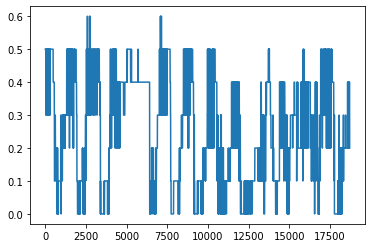

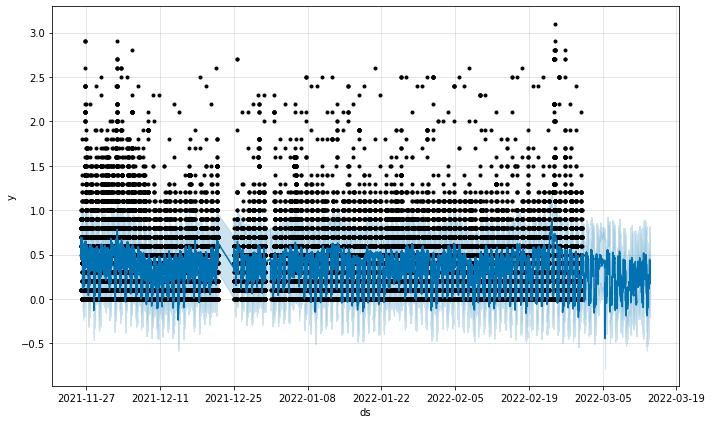

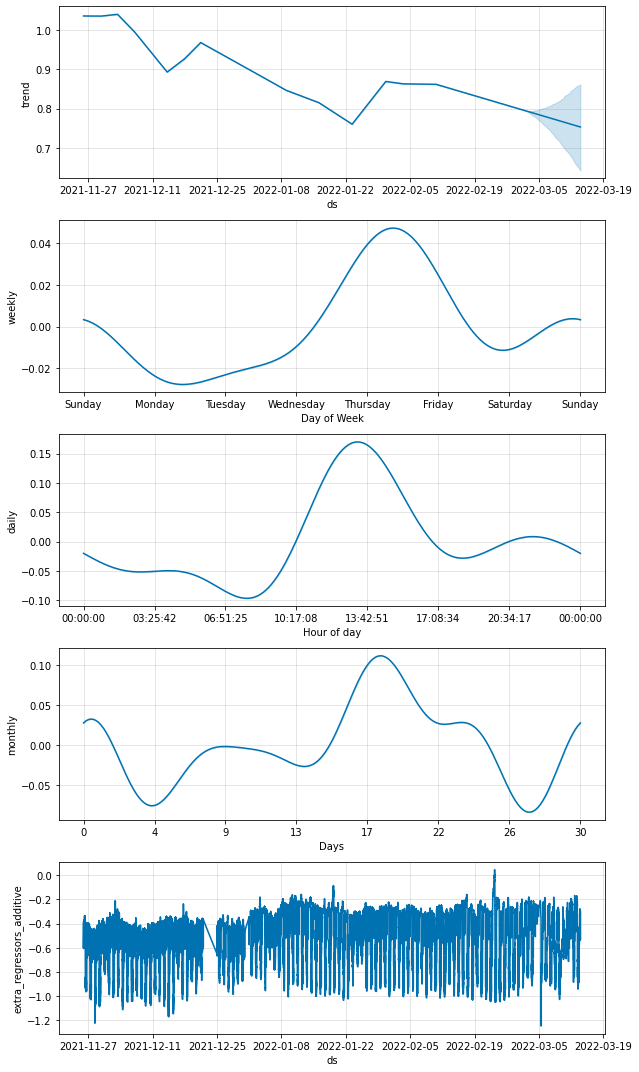

In [20]:
result_df = modeling(20,0.02,3.0)

절감 알고리즘에 의해 작동변수 및 내부온도가 변경된 test_df를 적용하여 절감된 열공급량 예측

06:56:04 - cmdstanpy - INFO - Chain [1] start processing
06:58:07 - cmdstanpy - INFO - Chain [1] done processing


------------
20,0.02,3.0
sum:4463.9
------------
date
2022-03-04    372.4
2022-03-05    366.6
2022-03-06    313.4
2022-03-07    436.7
2022-03-08    387.4
2022-03-09    332.7
2022-03-10    305.2
2022-03-11    321.3
2022-03-12    258.7
2022-03-13    367.3
2022-03-18    330.7
2022-03-19    375.4
2022-03-20    296.1
Name: 열공급량(kWh), dtype: float64
------------
rmse:0.2618187049595156


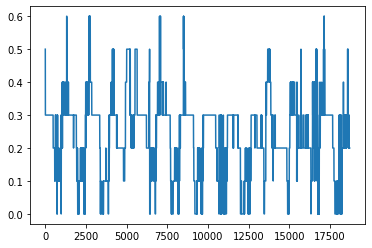

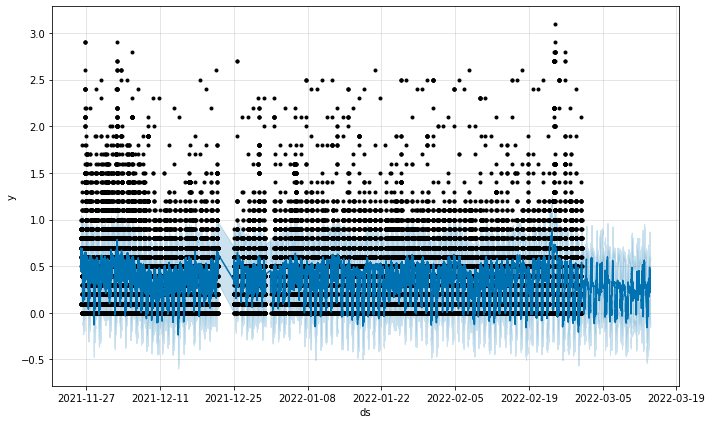

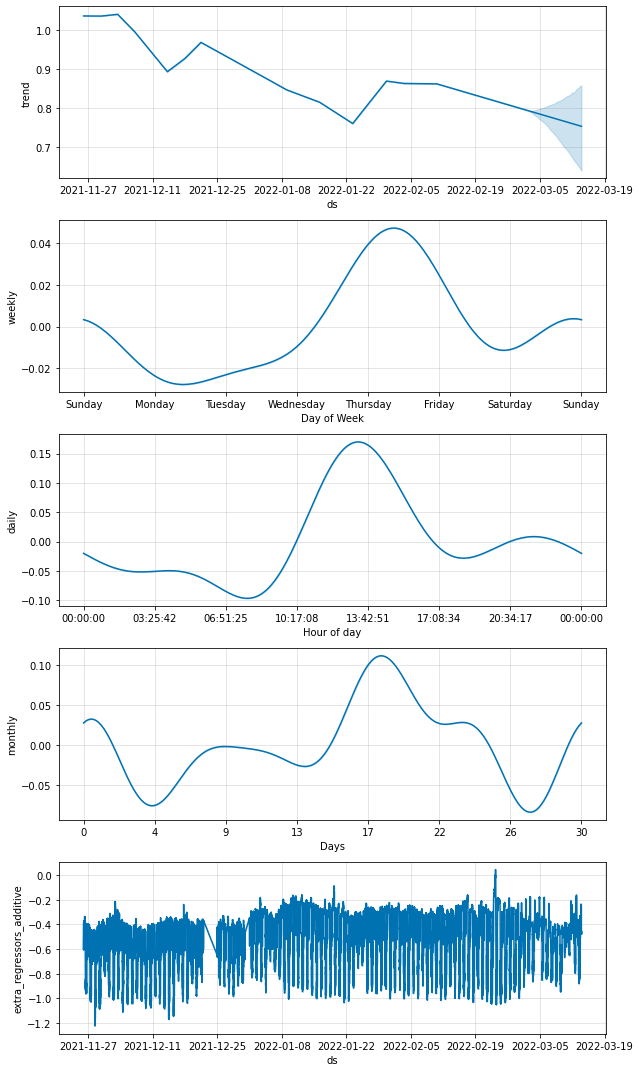

In [21]:
save_modeling(20,0.02,3.0)

In [22]:
result_df['time']=result_df['시간'].str.slice(start = 10,stop=20)

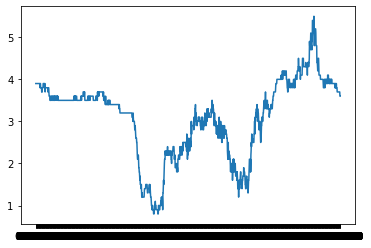

In [23]:
plt.plot(result_df.groupby('time')['열공급량(kWh)'].sum())